In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-10-16 13:31.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%s/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)

act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act = scv.read(act_h5ad)

act_arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_arm = scv.read(act_arm_h5ad)

act_cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_cl13 = scv.read(act_cl13_h5ad)

arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_ARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_arm = scv.read(arm_h5ad)

cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_CL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_cl13 = scv.read(cl13_h5ad)

adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_cl13, order_df, louvain_new_ordered, louvain_old_ordered)

adata_act.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act.obs.index.tolist()]
adata_act_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_arm.obs.index.tolist()]
adata_act_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_cl13.obs.index.tolist()]
adata_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_arm.obs.index.tolist()]
adata_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_cl13.obs.index.tolist()]

In [8]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

## Velocity embedding stream

saving figure to file ./figures/scvelo_velocity_embedding_stream.png


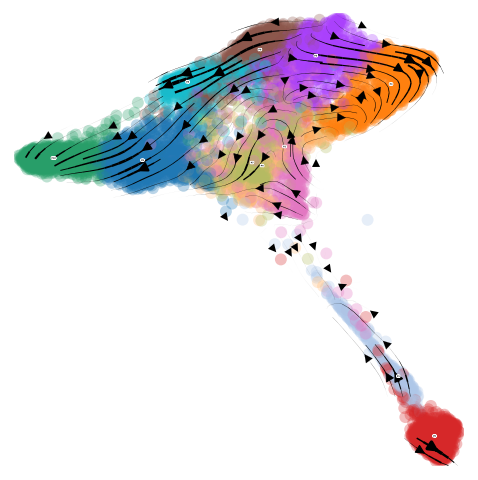

In [76]:
### Velocity embedding stream with PAGA FA2 projection
save_name = 'velocity_embedding_stream'

### Plot
rcParams['figure.figsize'] = 4,4
scv.pl.velocity_embedding_stream(adata, basis='paga', legend_fontsize=0, frameon=False, title="", save=save_name+".png")

## Root & Terminal status

saving figure to file ./figures/scvelo_act_root.png


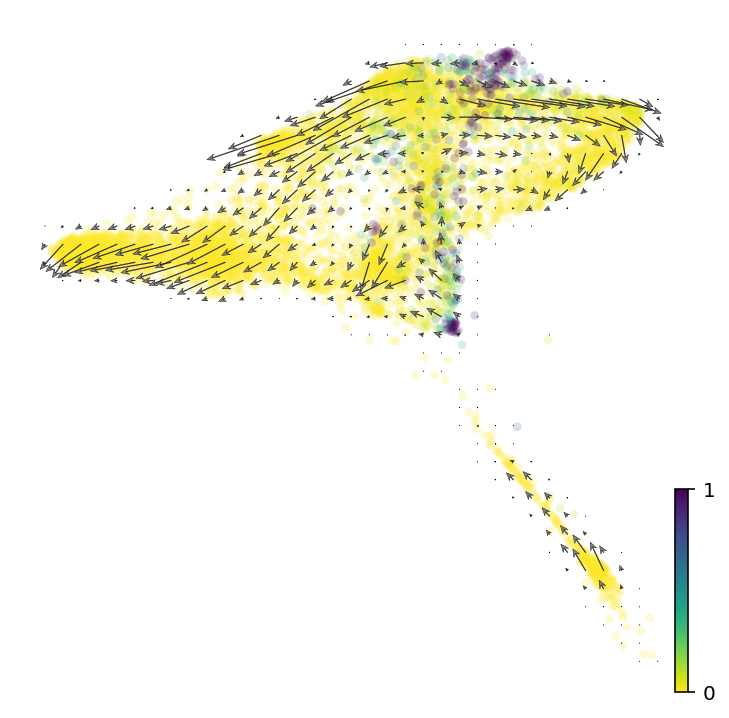

In [311]:
### Root & Terminal status
save_name = 'act_root'

### Plot
rcParams['figure.figsize'] = 6,6
scv.pl.velocity_embedding_grid(adata_act, basis='paga',density=0.7, arrow_size=2, arrow_length=3, title="", color=['root_cells'], save=save_name + ".png")

saving figure to file ./figures/scvelo_act_end.png


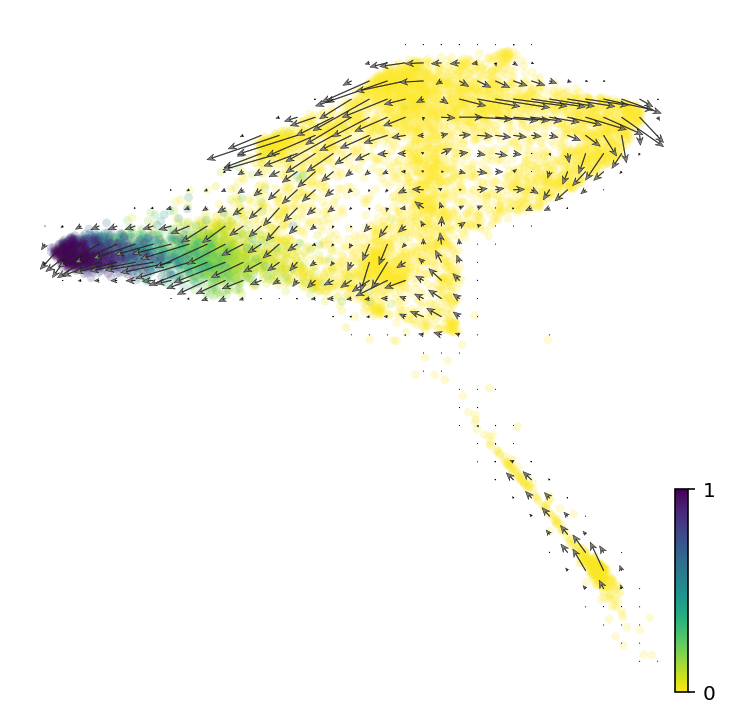

In [310]:
### Root & Terminal status
save_name = 'act_end'

### Plot
rcParams['figure.figsize'] = 6,6
scv.pl.velocity_embedding_grid(adata_act, basis='paga',density=0.7, arrow_size=2, arrow_length=3, title="", color=['end_points'], save=save_name + ".png")

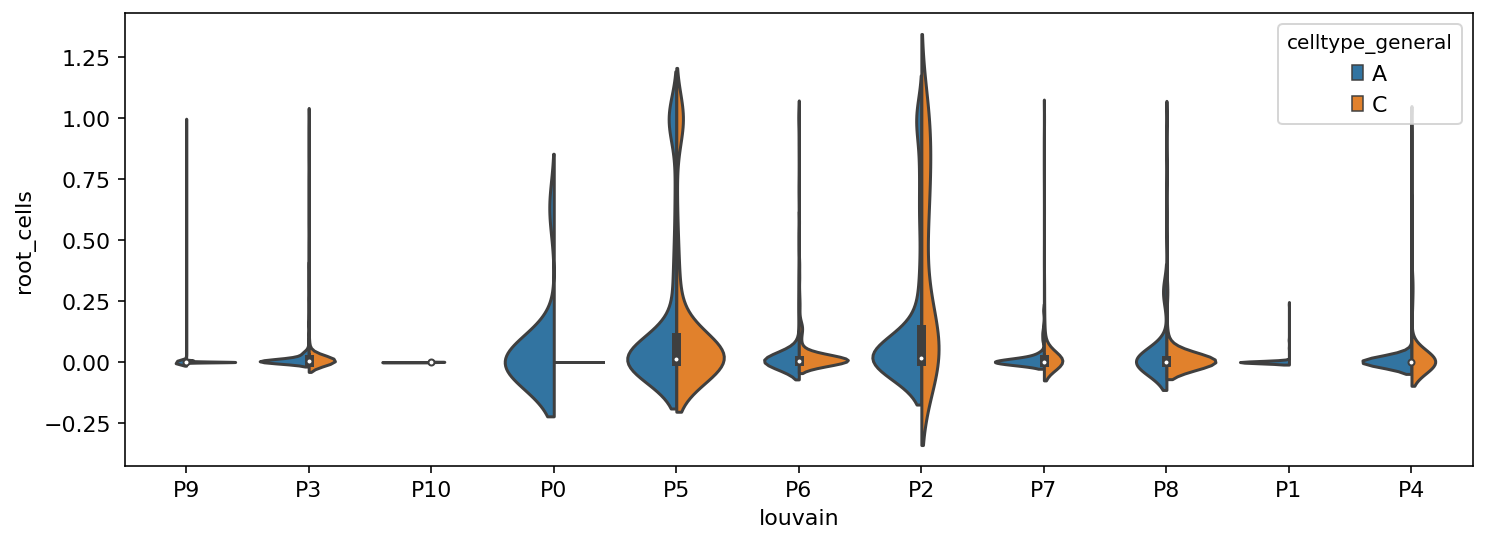

In [88]:
rcParams['figure.figsize'] = 12,4
sns.violinplot(data=adata_act.obs, x='louvain', y='root_cells', hue='celltype_general', split=True)

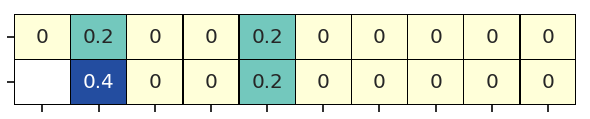

In [240]:
### Root status
save_name = 'act_root_heatmap'

### Plot
rcParams['figure.figsize'] = 5,0.8
adata_act_df = adata_act.obs[['louvain', 'celltype_general', 'root_cells']].groupby(['louvain', 'celltype_general']).mean().reset_index()
adata_act_df = adata_act_df.pivot(index='celltype_general', columns='louvain')
adata_act_df.columns = [x[1] for x in adata_act_df.columns]
adata_act_df = adata_act_df[louvain_new_ordered[1:]]
adata_act_df.index.name = ''
adata_act_df = adata_act_df.round(1)
heatmap = sns.heatmap(adata_act_df, cmap="YlGnBu", vmin=0, vmax=0.5, linecolor='black', linewidth=0.2, annot=True, cbar=False)
plt.savefig(save_name + ".png")
heatmap.set(xticklabels=[])
heatmap.set(yticklabels=[])
plt.savefig(save_name + "_nolabels.png")
plt.show()
plt.close()

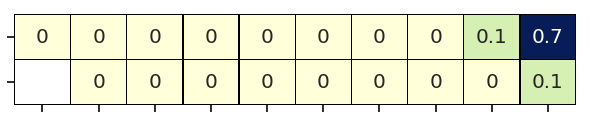

In [239]:
###---- End status
save_name = 'act_end_heatmap'

### Plot
rcParams['figure.figsize'] = 5,0.8
adata_act_df = adata_act.obs[['louvain', 'celltype_general', 'end_points']].groupby(['louvain', 'celltype_general']).mean().reset_index()
adata_act_df = adata_act_df.pivot(index='celltype_general', columns='louvain')
adata_act_df.columns = [x[1] for x in adata_act_df.columns]
adata_act_df = adata_act_df[louvain_new_ordered[1:]]
adata_act_df.index.name = ''
adata_act_df = adata_act_df.round(1)
heatmap = sns.heatmap(adata_act_df, cmap="YlGnBu", vmin=0, vmax=0.5, linecolor='black', linewidth=0.2, annot=True, cbar=False)
plt.savefig(save_name + ".png")
heatmap.set(xticklabels=[])
heatmap.set(yticklabels=[])
plt.savefig(save_name + "_nolabels.png")
plt.show()
plt.close()

## Transition probability

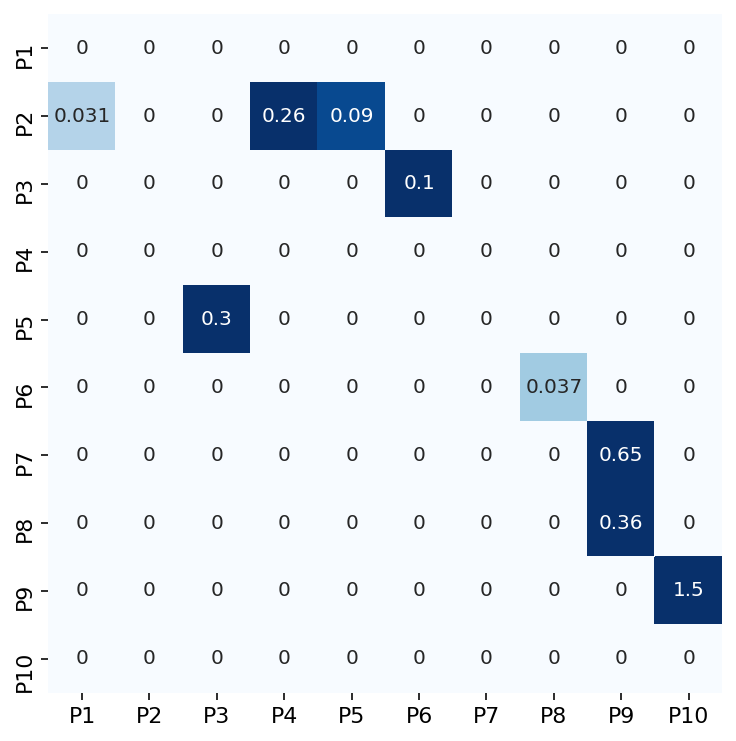

In [264]:
###---- Arm transition probability
save_name = 'act_arm_transition'

### Plot
rcParams['figure.figsize'] = 6,6

df = scv.get_df(adata_act_arm, 'paga/transitions_confidence', precision=2).T
df.columns = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.columns ]
df.index = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.index ]
use_louvain_order = [x for x in louvain_new_ordered[1:] if x in df.index.tolist()]
df = df[use_louvain_order]
df = df.loc[use_louvain_order]
sns.heatmap(df, annot=True, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
plt.savefig(save_name + ".png")
plt.show()
plt.close()

saving figure to file ./figures/scvelo_act_arm_transition_node.png


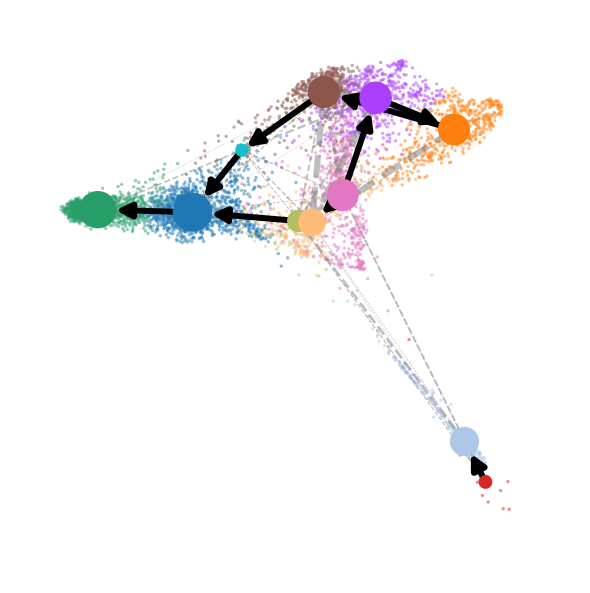

In [265]:
###---- Armstrong transition probability node plot
save_name = 'act_arm_transition_node'

### Plot
rcParams['figure.figsize'] = 5,5
scv.pl.paga(adata_act_arm, basis='paga', min_edge_width=3, node_size_scale=1.5, legend_loc=None, title="", 
            xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax),save=save_name+".png")

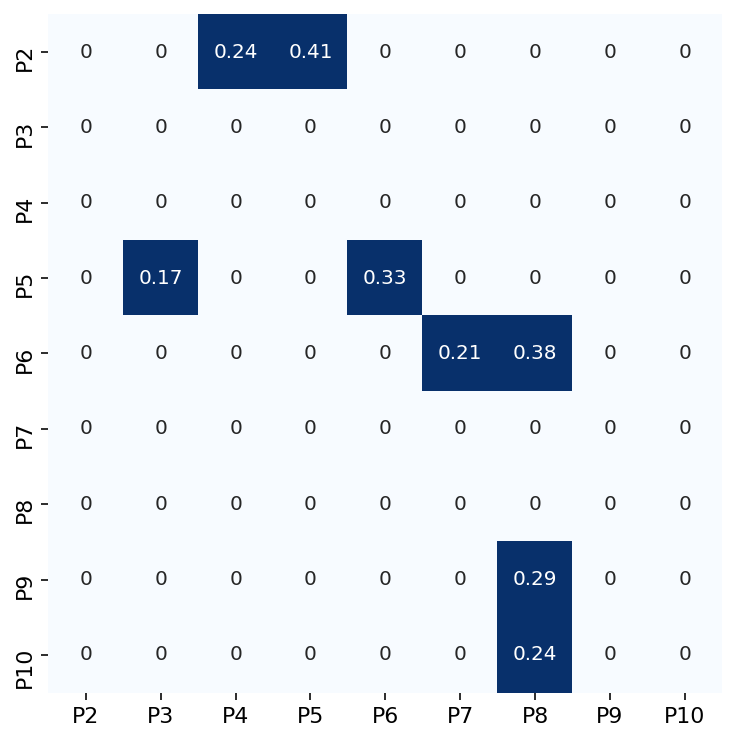

In [266]:
###---- Cl13 transition probability
save_name = 'act_cl13_transition'

### Plot
rcParams['figure.figsize'] = 6,6

df = scv.get_df(adata_act_cl13, 'paga/transitions_confidence', precision=2).T
df.columns = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.columns ]
df.index = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in df.index ]
use_louvain_order = [x for x in louvain_new_ordered[1:] if x in df.index.tolist()]
df = df[use_louvain_order]
df = df.loc[use_louvain_order]
sns.heatmap(df, annot=True, cmap='Blues', vmin=0, vmax=0.1, cbar=False)
plt.savefig(save_name + ".png")
plt.show()
plt.close()

saving figure to file ./figures/scvelo_act_cl13_transition_node.png


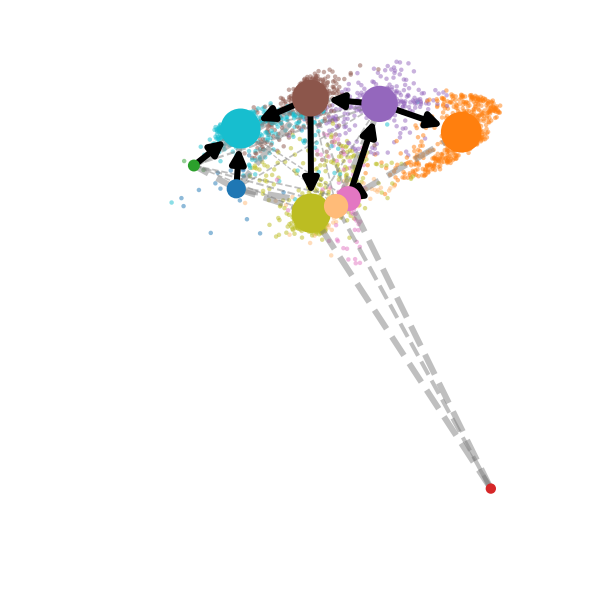

In [307]:
###---- Cl13 transition probability node plot
save_name = 'act_cl13_transition_node'

### Plot
rcParams['figure.figsize'] = 5,5
scv.pl.paga(adata_act_cl13, basis='paga', min_edge_width=3, node_size_scale=1.5, legend_loc=None, title="", 
            xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), save=save_name+".png")

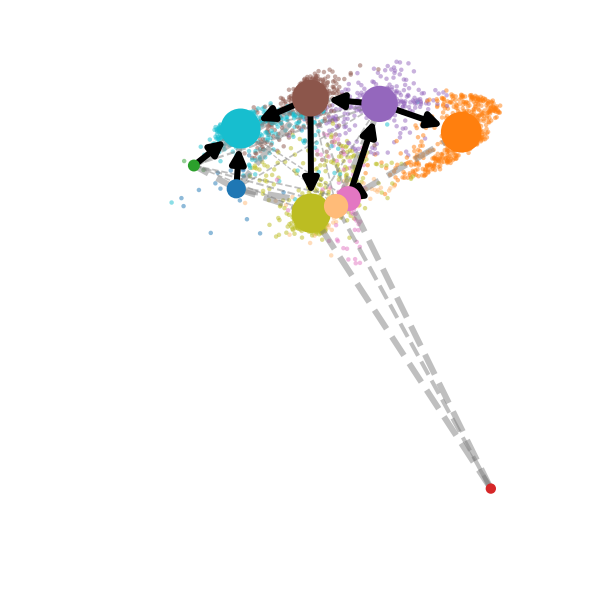

In [9]:
###---- Cl13 transition probability node plot
save_name = 'act_cl13_transition_node'

### Plot
rcParams['figure.figsize'] = 5,5
scv.pl.paga(adata_act_cl13, basis='paga', min_edge_width=3, node_size_scale=1.5, legend_loc=None, title="", 
            xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax))

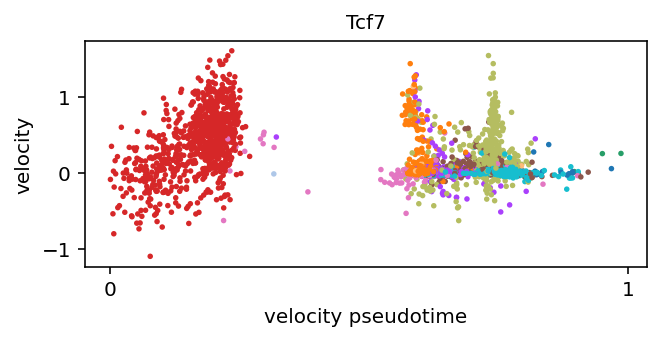

In [60]:
rcParams['figure.figsize'] = 5,2
scv.pl.scatter(adata_cl13, x='velocity_pseudotime', y="Tcf7", layer='velocity')

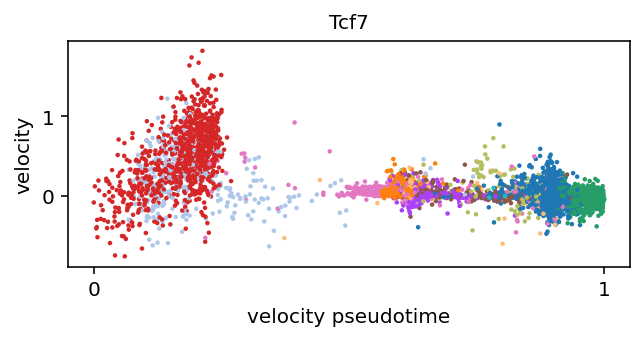

In [61]:
scv.pl.scatter(adata_arm, x='velocity_pseudotime', y="Tcf7", layer='velocity')

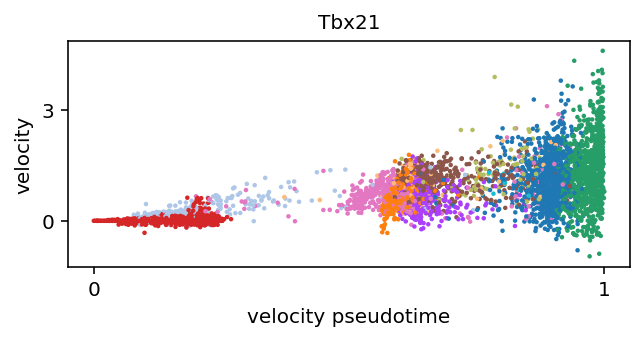

In [62]:
scv.pl.scatter(adata_arm, x='velocity_pseudotime', y="Tbx21", layer='velocity')

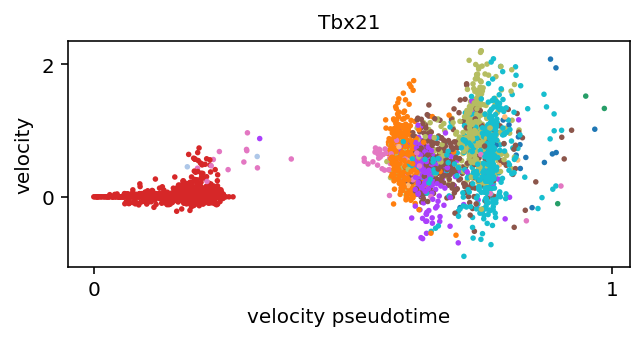

In [63]:
scv.pl.scatter(adata_cl13, x='velocity_pseudotime', y="Tbx21", layer='velocity')

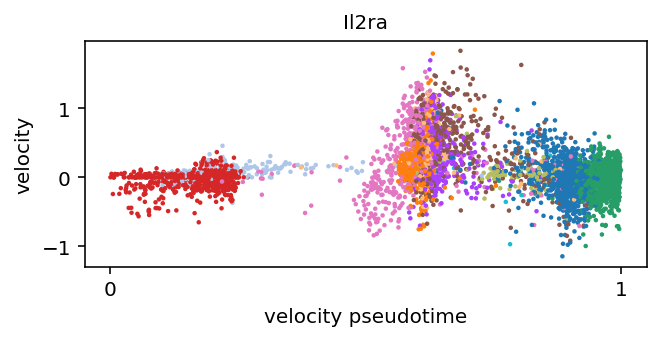

In [64]:
scv.pl.scatter(adata_arm, x='velocity_pseudotime', y="Il2ra", layer='velocity')

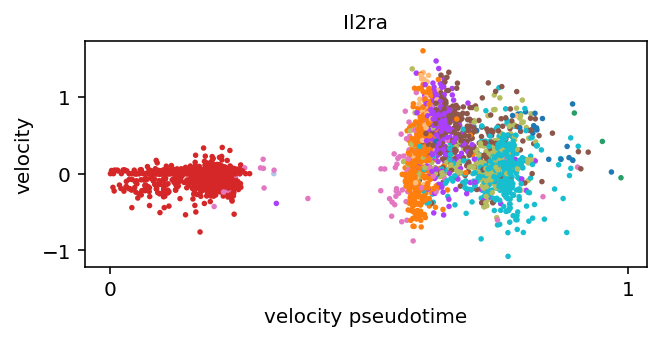

In [65]:
scv.pl.scatter(adata_cl13, x='velocity_pseudotime', y="Il2ra", layer='velocity')

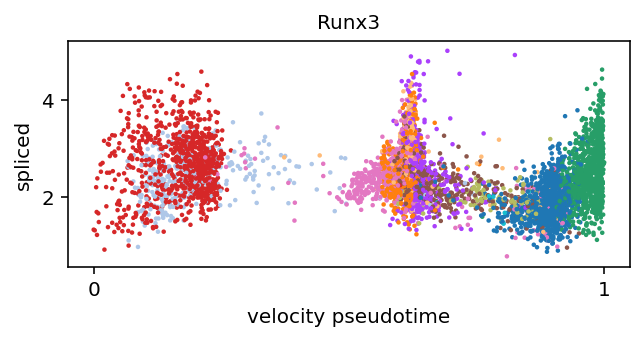

In [77]:
scv.pl.scatter(adata_arm, x='velocity_pseudotime', y="Runx3", layer='Ms')

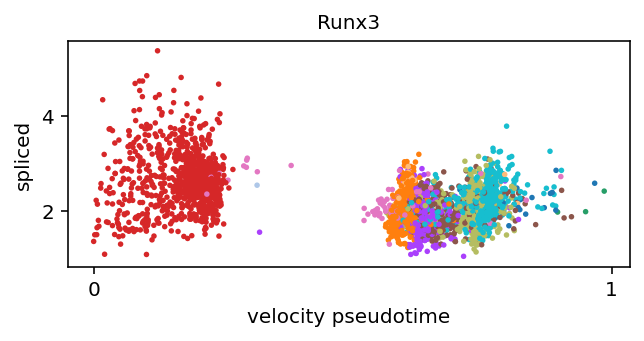

In [78]:
scv.pl.scatter(adata_cl13, x='velocity_pseudotime', y="Runx3", layer='Ms')

In [46]:
adata

AnnData object with n_obs × n_vars = 7803 × 9043
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'scanpy_paga', 'cell_type', 'louvain', 'dpt_pseudotime', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'louvain_celltype', 'celltype_general', 'louvain_old', 'Infection type', 'cell_id'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling'
    uns: 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'louvain_old_colors'
    obsm: 'X_paga', 'X_pca', 'paga', 'velocity_paga'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 